<a href="https://colab.research.google.com/github/Hveemos/did/blob/main/prophet_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640979 sha256=ba8b4fa95870512db51c693990dee035e8614fc4251ce7739226b39ea6e9ecd0
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [17]:
import requests
import json
import pandas as pd
import numpy as np

In [18]:
q={
  "query": [
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000004VU"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [19]:
session = requests.Session()
url='http://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM'
response = session.post(url, json=q)
response_json = json.loads(response.content.decode('utf-8-sig'))

In [20]:
def make_df(respons_dict):
  """Sätter ihop både etiketter och värden till en lista med listor"""
  vals=[]
  for row in respons_dict['data']:
    vals.append(row['key']+row['values'])
  return pd.DataFrame(vals, columns=[row['text'] for row in response_json['columns']])

In [21]:
df=make_df(response_json)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   månad                 505 non-null    object
 1   KPI, fastställda tal  505 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [22]:
pd.to_datetime(df['månad'],format='%YM%m') + pd.tseries.offsets.MonthEnd(1)

0     1980-01-31
1     1980-02-29
2     1980-03-31
3     1980-04-30
4     1980-05-31
         ...    
500   2021-09-30
501   2021-10-31
502   2021-11-30
503   2021-12-31
504   2022-01-31
Name: månad, Length: 505, dtype: datetime64[ns]

In [23]:
df['ds']=pd.to_datetime(df['månad'],format='%YM%m') + pd.tseries.offsets.MonthEnd(1)

In [24]:
df.head()

,månad,"KPI, fastställda tal",ds
0,1980M01,95.30,1980-01-31
1,1980M02,96.80,1980-02-29
2,1980M03,97.20,1980-03-31
3,1980M04,97.90,1980-04-30
4,1980M05,98.20,1980-05-31


In [25]:
df.rename(columns={'KPI, fastställda tal':'y'},inplace=True)

In [26]:
df=df[['ds','y']]
df['y']=df['y'].astype(float)
df.head()
df=df.set_index('ds')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
from prophet import Prophet
df.head()

,y
ds,
1980-01-31,95.3
1980-02-29,96.8
1980-03-31,97.2
1980-04-30,97.9
1980-05-31,98.2


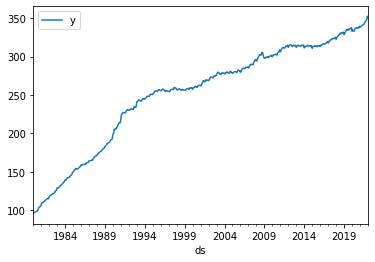

In [28]:
# plot the time series
import matplotlib.pyplot as plt
df.plot()
plt.show()

In [29]:
...
# prepare expected column names
df.reset_index(inplace=True)

In [30]:
m = Prophet()
#m.add_country_holidays(country_name='SE')

In [31]:
m.fit(df)
#m.train_holiday_names

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = m.make_future_dataframe(periods=12, freq='M')
future.tail(12)

,ds
505,2022-02-28
506,2022-03-31
507,2022-04-30
508,2022-05-31
509,2022-06-30
510,2022-07-31
511,2022-08-31
512,2022-09-30
513,2022-10-31
514,2022-11-30


In [33]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
512,2022-09-30,346.121468,343.375814,349.245186
513,2022-10-31,346.491555,343.681900,349.568426
514,2022-11-30,346.507283,343.563606,349.566384
515,2022-12-31,346.790111,343.941648,349.827086
516,2023-01-31,346.115335,342.964145,349.339869


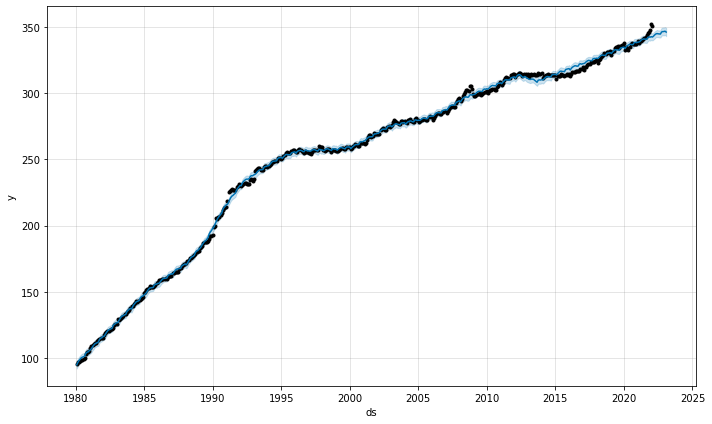

In [34]:
fig1 = m.plot(forecast)

In [35]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [36]:
plot_components_plotly(m, forecast)

In [37]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          517 non-null    datetime64[ns]
 1   trend                       517 non-null    float64       
 2   yhat_lower                  517 non-null    float64       
 3   yhat_upper                  517 non-null    float64       
 4   trend_lower                 517 non-null    float64       
 5   trend_upper                 517 non-null    float64       
 6   additive_terms              517 non-null    float64       
 7   additive_terms_lower        517 non-null    float64       
 8   additive_terms_upper        517 non-null    float64       
 9   yearly                      517 non-null    float64       
 10  yearly_lower                517 non-null    float64       
 11  yearly_upper                517 non-null    float64       

In [38]:
inflation=forecast[['yhat']].pct_change(periods=1)
inflation['yearly_pred']=forecast[['yhat']].pct_change(periods=12)
inflation.rename(columns={'yhat':'monthly_pred'}, inplace=True)

In [39]:
inflation.index=forecast['ds']

In [40]:
inflation

,monthly_pred,yearly_pred
ds,,
1980-01-31,NaN,NaN
1980-02-29,0.017842,NaN
1980-03-31,0.015736,NaN
1980-04-30,0.010510,NaN
1980-05-31,0.011058,NaN
...,...,...
2022-09-30,0.004401,0.011752
2022-10-31,0.001069,0.011763
2022-11-30,0.000045,0.012322


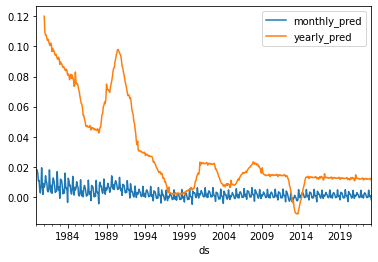

In [41]:
inflation.plot()

In [42]:
inflation_observed=df[['y']].pct_change(periods=1)
inflation_observed.rename(columns={'y':'monthly'}, inplace=True)

In [43]:
inflation_observed['yearly']=df['y'].pct_change(periods=12)

In [44]:
inflation_observed.index=df['ds']

In [45]:
inflation.tail()

,monthly_pred,yearly_pred
ds,,
2022-09-30,0.004401,0.011752
2022-10-31,0.001069,0.011763
2022-11-30,0.000045,0.012322
2022-12-31,0.000816,0.012171
2023-01-31,-0.001946,0.011026


In [46]:
import datetime

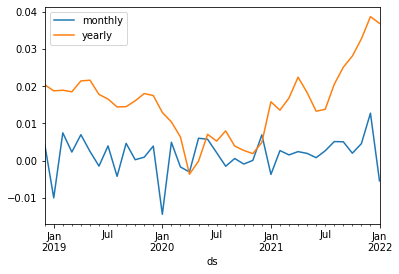

In [48]:
st = datetime.datetime(2018, 12, 31)
inflation_observed[st:].plot()

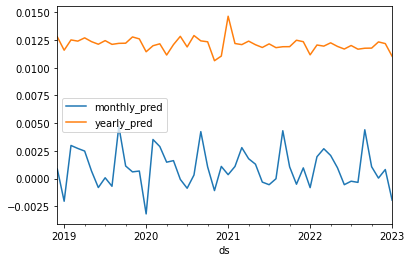

In [49]:
inflation[st:].plot()

Text(0.5, 1.0, 'Monthly inflation')

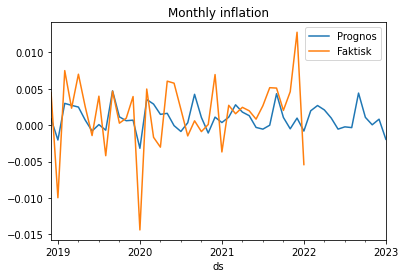

In [50]:
inflation[st:]['monthly_pred'].plot(label='Prognos')
inflation_observed[st:]['monthly'].plot(label='Faktisk')
plt.legend()
plt.title('Monthly inflation')

Text(0.5, 1.0, 'Yearly inflation')

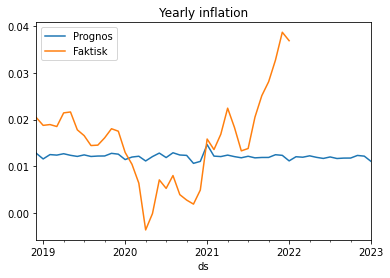

In [56]:
inflation[st:]['yearly_pred'].plot(label='Prognos')
inflation_observed[st:]['yearly'].plot(label='Faktisk')
plt.legend(loc='upper left')
plt.title('Yearly inflation')

In [57]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-31,95.940428,92.039172,97.435057,95.940428,95.940428,-1.134968,-1.134968,-1.134968,-1.134968,-1.134968,-1.134968,0.0,0.0,0.0,94.805460
1,1980-02-29,96.777443,93.779880,99.076110,96.777443,96.777443,-0.280492,-0.280492,-0.280492,-0.280492,-0.280492,-0.280492,0.0,0.0,0.0,96.496951
2,1980-03-31,97.672182,95.270483,100.732039,97.672182,97.672182,0.343267,0.343267,0.343267,0.343267,0.343267,0.343267,0.0,0.0,0.0,98.015450
3,1980-04-30,98.538060,96.391607,101.794721,98.538060,98.538060,0.507497,0.507497,0.507497,0.507497,0.507497,0.507497,0.0,0.0,0.0,99.045557
4,1980-05-31,99.432799,97.475492,102.757577,99.432799,99.432799,0.707987,0.707987,0.707987,0.707987,0.707987,0.707987,0.0,0.0,0.0,100.140786
